In [1]:
protein = "MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG"
from disassembly.simulate_proteolysis_regex import (
    ProteolysisSimulator,
    Enzyme
)
n_generate = 250

trypsin_regex = Enzyme("trypsin", {"(.)(.)([R|K])([^P])(.)(.)" : 1})
random_regex = Enzyme("random", {"(.)(.)(.)(.)(.)(.)": 1})
chymotrp_regex = Enzyme("chymotrypsin", {"(.)(.)([F|Y|W])([^P])(.)(.)(.)" : 1})
elastase_regex = Enzyme("elastase", {"(.)(.)([V|I|A|T])(.)(.)(.)":1})

In [2]:
generated_peptidomes = {"name": [], "peptidome": []}

names = ["trypsin", "chymotrypsin", "elastase", "random"]

ps = ProteolysisSimulator(verbose=False)
for enz, name in zip(
    [trypsin_regex, chymotrp_regex, elastase_regex, random_regex], names
):
    print(name)
    for i in range(10):
        print(f"\r{i}", end="", flush=True)
        generated_peptidome = ps.simulate_proteolysis(
            protein,
            n_start=1,
            n_generate=n_generate,
            endo_or_exo_probability=[0.8,0.2],
            enzyme=enz,
            graph=False,
        )
        generated_peptidomes["name"].append(f"{name}_{i}")
        generated_peptidomes["peptidome"].append(generated_peptidome)

trypsin
9chymotrypsin
9elastase
9random
9

In [3]:
from disassembly.util import KL
from disassembly.estimate_parameters import compare

comparisons = {}
for i in range(len(generated_peptidomes["peptidome"])):
    name_comp_1 = generated_peptidomes["name"][i]
    peptidome_comp_1 = generated_peptidomes["peptidome"][i]
    comparisons[name_comp_1] = {}
    for j in range(len(generated_peptidomes["peptidome"])):
        name_comp_2 = generated_peptidomes["name"][j]
        peptidome_comp_2 = generated_peptidomes["peptidome"][j]
        p, q = compare(peptidome_comp_1, peptidome_comp_2)
        err = KL(p, q) + KL(q, p)
        comparisons[name_comp_1][name_comp_2] = err

import pandas as pd

comps_df = pd.DataFrame(comparisons)

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


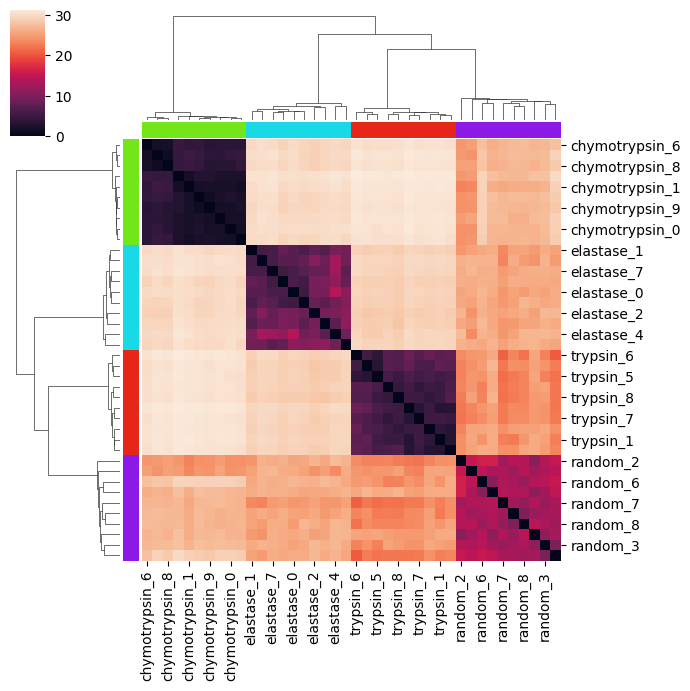

In [4]:
import seaborn as sns

lut = dict(zip(names, sns.hls_palette(len(names), l=0.5, s=0.8)))

lst = []
for i, n in enumerate(names):
    lst += [f"{n}"] * 10

row_colors = pd.DataFrame(lst)[0].map(lut)


sns.clustermap(
    comps_df,
    figsize=(7, 7),
    row_colors=row_colors.to_numpy(),
    col_colors=row_colors.to_numpy(),
)

In [5]:

enzyme = trypsin_regex

ps = ProteolysisSimulator()
true_dict, sequence_graph = ps.simulate_proteolysis(
    protein,
    n_start=1,
    n_generate=n_generate,
    endo_or_exo_probability=[0.9, 0.1],
    enzyme=enzyme,
    graph=True,
)

 249 / 250 (241)
66 unique peptides. 251 total


In [6]:
from disassembly.estimate_parameters_ga import ParameterEstimatorGA

pe = ParameterEstimatorGA(true_distribution=true_dict, protein_sequence=protein, mutation_rate=.9, n_individuals=30, pattern_len=6, kill_fraction=.5, n_generate=n_generate)

parameters = pe.run(
    n_generations=10
)

N Kill  15
Sorted  {([A])([^C])(.)([K])([A])([L]): 21.543704086534085, ([D])([^T])(.)(.)([G])([K]): 22.031684490444036, (.)([^N])(.)(.)([^C])(.): 22.804662304159034, ([P])(.)([L])([^W])([^D])(.): 22.98811783960267, (.)([E])(.)([G])([R])(.): 23.003801903759943, (.)(.)([Y])([^A])(.)([Y]): 23.16171089063994, ([P])(.)([^R])(.)([A])(.): 23.34610134719579, ([^N])([^N])(.)(.)(.)(.): 23.394338155500662, ([Q])([T])(.)([D])([H])([K]): 23.631011327182968, ([^M])(.)([E])([R])([^E])(.): 24.056101892531515, ([P])([^E])(.)(.)([C])(.): 24.182714655746118, ([^L])([^P])([E])([Q])([^A])([^H]): 25.016159816765242, ([A])(.)(.)([A])([S])([^Q]): 25.19487048969652, ([^K])(.)([P])([I])(.)(.): 25.566569364665277, ([^F])(.)([^T])([^H])([^W])(.): 25.81599415541728, ([P])(.)([Y])(.)(.)(.): 26.091618654919433, (.)(.)([F])(.)([^Y])([C]): 26.266732049312363, ([L])(.)(.)([^N])(.)([^K]): 26.33638134686962, ([P])([^F])(.)([^M])(.)([^N]): 26.643732479252304, ([^D])(.)([P])(.)([^T])([^N]): 26.704329543152177, ([^V])(.)([^

# Check if simulated proteolysis has a reasonable distance


In [7]:
import pandas as pd


df = pd.read_csv("../data/enzymes/processed.csv")
df = df[df["Protein Accession"] == "H4"]
df.set_index(["Peptide", "Protein Accession"], inplace=True)

In [8]:
pre_df = {}

for name, peptidome in zip(
    generated_peptidomes["name"], generated_peptidomes["peptidome"]
):
    pre_df[name] = peptidome
df_simulated = pd.DataFrame(pre_df)
df_simulated = df_simulated.reset_index().rename(columns={"index": "Peptide"})
df_simulated.head()

,Peptide,trypsin_0,trypsin_1,trypsin_2,trypsin_3,trypsin_4,trypsin_5,trypsin_6,trypsin_7,trypsin_8,...,random_0,random_1,random_2,random_3,random_4,random_5,random_6,random_7,random_8,random_9
0,MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKR...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,RISGLIYEETR,10.0,16.0,9.0,7.0,2.0,9.0,5.0,9.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
2,GGAKRHR,9.0,4.0,6.0,5.0,12.0,7.0,7.0,8.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MSGRGKGGKGLGK,7.0,1.0,5.0,5.0,5.0,7.0,5.0,10.0,3.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,RISGLIYEET,3.0,NaN,NaN,1.0,NaN,2.0,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
merged = df.reset_index().merge(df_simulated, left_on="Peptide", right_on="Peptide", how="outer")
merged = merged.set_index("Peptide").drop(columns=["Protein Accession"])
samples = merged.columns
merged

,cht1,cht2,cht3,cht4,cht5,cht6,cht7,cht8,cht9,cht10,...,random_0,random_1,random_2,random_3,random_4,random_5,random_6,random_7,random_8,random_9
Peptide,,,,,,,,,,,,,,,,,,,,,
RKTVTAMDVVYALKR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KTVTAMDVVYALKR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENVIRDAVTYTEHAKRKTVTAM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KTVTAMDVVYALK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KVFLENVIRDAVTYTEHAKRKTVTAM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHRKVLRDNIQG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
ENVIRDAVTYT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
HAKRKTVTAMD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [10]:
data_dict = {}

for sample in samples:
    sample_data = merged[sample].dropna().reset_index()

    protein_dict = {}

    peptide_dict = {}

    for i, row in sample_data.iterrows():
        peptide = row["Peptide"]
        abundance = row[sample]
        peptide_dict[peptide] = abundance
    protein_dict[protein] = peptide_dict
    data_dict[sample] = protein_dict
data_dict

{'cht1': {'MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG': {'RKTVTAMDVVYALKR': 0.0,
   'KTVTAMDVVYALKR': 0.0,
   'ENVIRDAVTYTEHAKRKTVTAM': 0.0,
   'KTVTAMDVVYALK': 0.0,
   'KVFLENVIRDAVTYTEHAKRKTVTAM': 0.0,
   'VIRDAVTYTEHAKRKTVTAM': 0.0,
   'VFLENVIRDAVTYTEHAKR': 0.0,
   'VFLENVIRDAVTY': 0.0,
   'TVTAMDVVYALKR': 0.0,
   'VFLENVIRDAVTYTEHAK': 0.0,
   'IRDAVTYTEHAKRKTVTAM': 0.0,
   'DNIQGITKPAIRR': 0.0,
   'DNIQGITKPAIR': 0.0,
   'VLRDNIQGITKPAIR': 1.0,
   'TAMDVVYALKR': 0.0,
   'RDNIQGITKPAIR': 2.0,
   'FLENVIRDAVTYT': 0.0,
   'FLENVIRDAVTYTEHA': 0.0,
   'VIRDAVTYTEHAK': 0.0,
   'VLRDNIQGITKPAIRR': 0.0,
   'VFLENVIRDAVT': 0.0,
   'ISGLIYEETR': 0.0,
   'NVIRDAVTYTEHAKRKTVTAM': 0.0,
   'AMDVVYALKR': 0.0,
   'ISGLIYEETRGVLK': 0.0,
   'KVFLENVIRDAVTY': 2.0,
   'RISGLIYEETR': 0.0,
   'NVIRDAVTYTEHAK': 0.0,
   'KVFLENVIRDAVTYTEHAKRKTVTA': 0.0,
   'TVTAMDVVYALK': 0.0,
   'VIRDAVTYTEHA': 0.0,
   'AVTYTEHAKRKTVTAM': 0.0,
   'MDVVYALKR': 

In [11]:
comparisons = {}
comparisons_asym = {}
for i in data_dict.keys():
    if protein in data_dict[i].keys():
        peptidome_comp_1 = data_dict[i][protein]
        comparisons[i] = {}
        comparisons_asym[i] = {}
        for j in data_dict.keys():
            if protein in data_dict[j].keys():
                peptidome_comp_2 = data_dict[j][protein]
                p, q = compare(peptidome_comp_1, peptidome_comp_2)

                comparisons[i][j] = KL(p, q) + KL(q, p)
                comparisons_asym[i][j] = KL(p,q)

In [12]:
import re

pattern1 = r"_[0-9]"
pattern2 = r"[0-9]"

groups = [re.sub(pattern2, "", re.sub(pattern1, "", s)) for s in samples]

synthetic = ["in vitro"] * 40 + ["in silico"] * 40

design = pd.DataFrame({"sample": samples, "group": groups, "synthetic": synthetic})

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


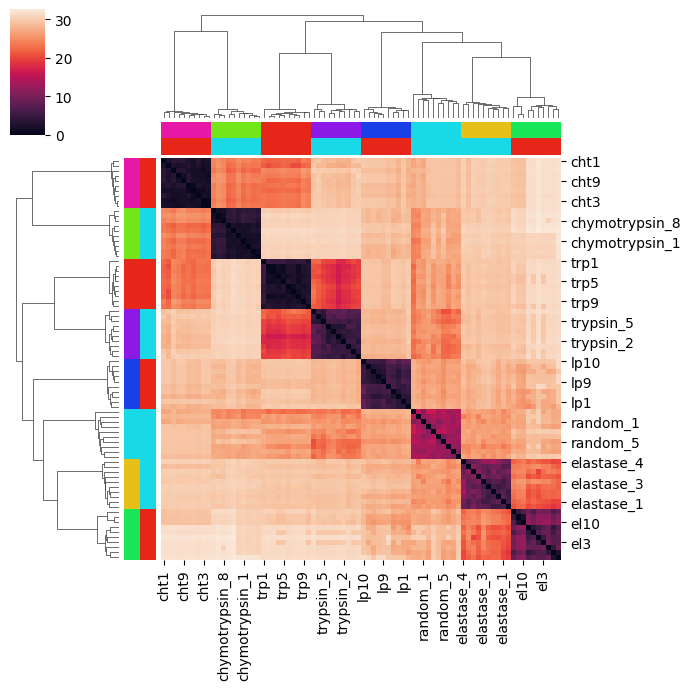

In [13]:
import seaborn as sns

labels1 = design["group"]
lut = dict(zip(set(labels1), sns.hls_palette(len(set(labels1)), l=0.5, s=0.8)))
row_colors1 = design["group"].map(lut)

labels2 = design["synthetic"]
lut = dict(zip(set(labels2), sns.hls_palette(len(set(labels2)), l=0.5, s=0.8)))
row_colors2 = design["synthetic"].map(lut)

comps_df = pd.DataFrame(comparisons)

sns.clustermap(
    comps_df,
    figsize=(7, 7),
    row_colors=[row_colors1.to_numpy(), row_colors2.to_numpy()],
    col_colors=[row_colors1.to_numpy(), row_colors2.to_numpy()],
    col_cluster=True,row_cluster=True
)

In [14]:
wanted_cols = [col for col in merged.columns if (col.startswith("trp") or col.startswith("trypsin"))]
kr_trp = merged[wanted_cols]
kr_trp

,trp1,trp2,trp3,trp4,trp5,trp6,trp7,trp8,trp9,trp10,trypsin_0,trypsin_1,trypsin_2,trypsin_3,trypsin_4,trypsin_5,trypsin_6,trypsin_7,trypsin_8,trypsin_9
Peptide,,,,,,,,,,,,,,,,,,,,
RKTVTAMDVVYALKR,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KTVTAMDVVYALKR,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENVIRDAVTYTEHAKRKTVTAM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KTVTAMDVVYALK,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,1.0,1.0,2.0,2.0,NaN,NaN,1.0,NaN,1.0
KVFLENVIRDAVTYTEHAKRKTVTAM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHRKVLRDNIQG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENVIRDAVTYT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HAKRKTVTAMD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


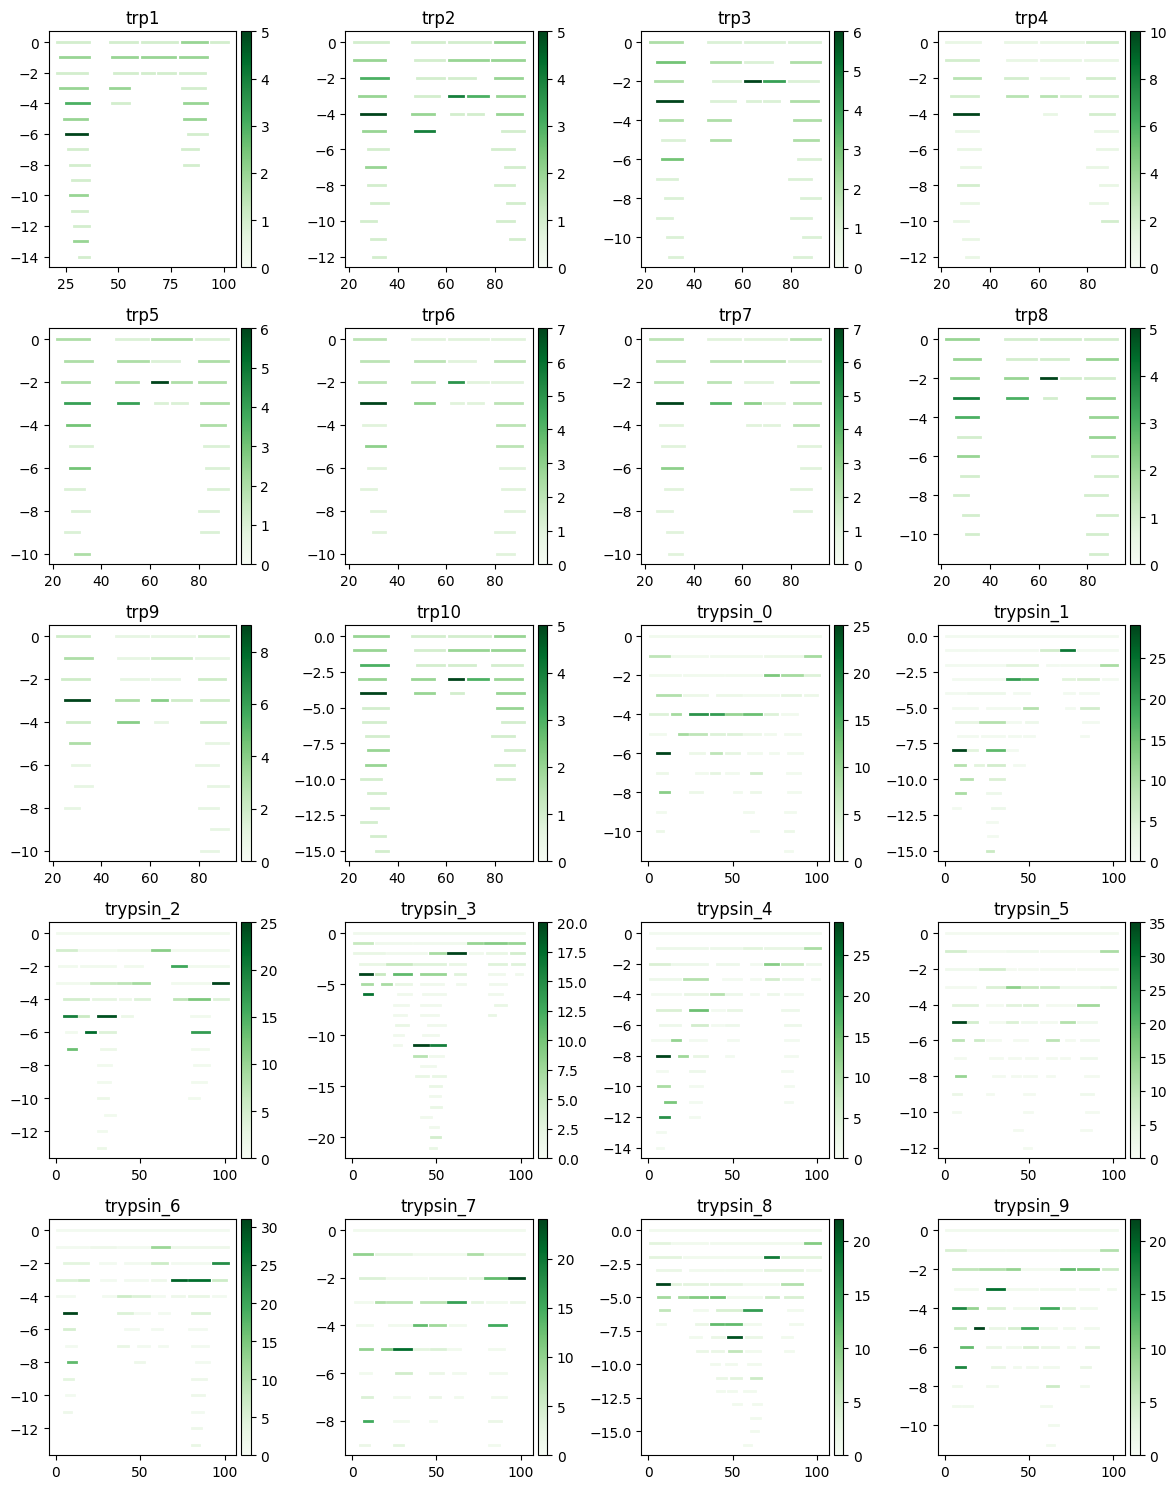

In [15]:
from disassembly.util import plot_peptidome
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(
    5,
    4,
    figsize=(12, 15),
)
samples = kr_trp.columns.tolist()
for col, ax in zip(kr_trp.columns, axs.ravel()):
    d = kr_trp[col]
    i = kr_trp.columns.tolist().index(col)

    ax.set_title(f"{col}")
    d = d.replace(0,np.nan).dropna()

    plot_peptidome(
        protein,
        d,
        ax,
    )
plt.tight_layout()